# Exploring the Dataset

For this project I am using the [Trending YouTube Video Statistics](https://www.kaggle.com/datasnaek/youtube-new) dataset from Kaggle. Moreover, I am using the `GBvideos.csv` and `GB_category_id.json` files.

`GBvideos.csv` contains details about the videos which have gone trending on YouTube between 17/11/2017 and 14/06/2018. These details include qualitive descriptions of the video (title, tags, description) and some of its quantitative achievements (views, likes, number of comments). The dataset includes an entry for each day a video was trending as well as the details for that video at the end of that day.

`GB_category_id.json` contains details about the categories a video can be assigned to and the numerical id for each category.

# Table of Contents
- [Data Preparation](#Data-Preparation)
    - [Trending Videos](#Trending-Videos)
    - [Video Categories](#Video-Categories)
- [Data Manipulation](#Data-Manipulation)
    - [Summarise Data for Each Video](#Summarise-Data-for-Each-Video)
- [Data Exploration](#Data-Exploration)
    - [Views, Comments, Ratings](#Views,-Comments,-Ratings)

# Data Preparation

In [1]:
import pandas as pd
import numpy as np

## Trending Videos

In [2]:
# Read data
df=pd.read_csv("data/GBvideos.csv",parse_dates=["trending_date","publish_time"])
print("Table has {:,} rows & {:,} columns ({:,} unique videos)".format(df.shape[0],df.shape[1],len(df["video_id"].unique())))

Table has 38,916 rows & 16 columns (3,272 unique videos)


In [3]:
# Preview data
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10 07:38:29+00:00,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12 06:24:44+00:00,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,17.14.11,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13 02:30:38+00:00,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,17.14.11,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13 01:45:13+00:00,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...


In [4]:
# Datatypes of each column
df.dtypes

video_id                               object
trending_date                          object
title                                  object
channel_title                          object
category_id                             int64
publish_time              datetime64[ns, UTC]
tags                                   object
views                                   int64
likes                                   int64
dislikes                                int64
comment_count                           int64
thumbnail_link                         object
comments_disabled                        bool
ratings_disabled                         bool
video_error_or_removed                   bool
description                            object
dtype: object

## Video Categories

In [5]:
import json

with open("data\GB_category_id.json") as f:
    d=json.load(f)
categories=pd.json_normalize(d['items'])[["id","snippet.title"]] # flatten the json
categories.columns=["category_id","category_name"] # more friendly column names
categories["category_id"]=categories["category_id"].astype(int)
categories=categories.set_index("category_id")

categories

,category_name
category_id,
1,Film & Animation
2,Autos & Vehicles
10,Music
15,Pets & Animals
17,Sports
18,Short Movies
19,Travel & Events
20,Gaming
21,Videoblogging


# Data Manipulation

To make the provided in `df` more usable I:
 - Parse `trending_date` into a `datetime` object. This allows it to be sorted.
 - Add category names as a column of the main dataframe.
 - Converted the tags string into a set of the unique terms used.
 - Calculated the 'like ratio' for each video
 

I produce a new dataframe `unique_df` which includes a single entry for each video and contains a summary of the data about that video.

In [6]:
# parse trending date
df["trending_date"]=pd.to_datetime(df["trending_date"],format='%y.%d.%m', errors='coerce')
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10 07:38:29+00:00,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,2017-11-14,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,24,2017-11-12 06:24:44+00:00,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,2017-11-14,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10 17:00:03+00:00,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
3,PUTEiSjKwJU,2017-11-14,Goals from Salford City vs Class of 92 and Fri...,Salford City Football Club,17,2017-11-13 02:30:38+00:00,"Salford City FC|""Salford City""|""Salford""|""Clas...",27833,193,12,37,https://i.ytimg.com/vi/PUTEiSjKwJU/default.jpg,False,False,False,Salford drew 4-4 against the Class of 92 and F...
4,rHwDegptbI4,2017-11-14,Dashcam captures truck's near miss with child ...,Cute Girl Videos,25,2017-11-13 01:45:13+00:00,[none],9815,30,2,30,https://i.ytimg.com/vi/rHwDegptbI4/default.jpg,False,False,False,Dashcam captures truck's near miss with child ...


In [7]:
# add categories
df=df.merge(categories,on="category_id")
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,Jw1Y-zhQURU,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10 07:38:29+00:00,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style
1,MyEqfBkzESU,2017-11-14,EXTREME GOLDEN TAN TRANSFORMATION,John Maclean,26,2017-11-10 20:40:44+00:00,"Extreme Tan|""Tanning""|""Tanning Bed""|""How to ge...",300617,8133,2693,2911,https://i.ytimg.com/vi/MyEqfBkzESU/default.jpg,False,False,False,-\n\n\nWebsite - http://www.johnmaclean.co.uk\...,Howto & Style
2,b4vTZx_AtHk,2017-11-14,How To Dry a Shirt in 30 Seconds,HowToBasic,26,2017-11-09 18:36:48+00:00,"how to dry a shirt in 30 seconds|""how to dry a...",2063667,98804,11682,11443,https://i.ytimg.com/vi/b4vTZx_AtHk/default.jpg,False,False,False,Today I show you how to completely dry a shirt...,Howto & Style
3,OWvCCu2t6Ts,2017-11-14,SO Much To Tell You | 32 Weeks Pregnant | MOTH...,Sprinkleofglitter,26,2017-11-10 16:59:50+00:00,"sprinkleofglitter|""sprinkle of glitter""|""Louis...",238843,10028,248,650,https://i.ytimg.com/vi/OWvCCu2t6Ts/default.jpg,False,False,False,A big chat about everything going on in my pre...,Howto & Style
4,9GqL1DSQDL0,2017-11-14,GET READY WITH ME + LILY! (we're so immature bye),makeupbymichaelfinch,26,2017-11-09 22:00:00+00:00,"Lily brown|""michael finch""|""makeupbymichaelfin...",332967,22303,700,1523,https://i.ytimg.com/vi/9GqL1DSQDL0/default.jpg,False,False,False,Hey babes! Happy Friday! It's the WEEKENDDD He...,Howto & Style


In [8]:
# tags to list
tags=df["tags"].str.extractall("([^\"\|]*)").groupby(level=0)[0].apply(lambda x: set(x))

# remove null values
for tag in tags:
    tag-={np.NaN,"[none]"}
df["tags"]=tags
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,Jw1Y-zhQURU,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10 07:38:29+00:00,"{john lewis christmas advert, john lewis chris...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style
1,MyEqfBkzESU,2017-11-14,EXTREME GOLDEN TAN TRANSFORMATION,John Maclean,26,2017-11-10 20:40:44+00:00,"{Tanning, Extreme Tan, How to apply fake tan, ...",300617,8133,2693,2911,https://i.ytimg.com/vi/MyEqfBkzESU/default.jpg,False,False,False,-\n\n\nWebsite - http://www.johnmaclean.co.uk\...,Howto & Style
2,b4vTZx_AtHk,2017-11-14,How To Dry a Shirt in 30 Seconds,HowToBasic,26,2017-11-09 18:36:48+00:00,"{quickly dry clothes, life hack, how to dry a ...",2063667,98804,11682,11443,https://i.ytimg.com/vi/b4vTZx_AtHk/default.jpg,False,False,False,Today I show you how to completely dry a shirt...,Howto & Style
3,OWvCCu2t6Ts,2017-11-14,SO Much To Tell You | 32 Weeks Pregnant | MOTH...,Sprinkleofglitter,26,2017-11-10 16:59:50+00:00,"{uk mum vlogger, sprinkleofglitter, Choosing a...",238843,10028,248,650,https://i.ytimg.com/vi/OWvCCu2t6Ts/default.jpg,False,False,False,A big chat about everything going on in my pre...,Howto & Style
4,9GqL1DSQDL0,2017-11-14,GET READY WITH ME + LILY! (we're so immature bye),makeupbymichaelfinch,26,2017-11-09 22:00:00+00:00,"{makeupbymichaelfinch, bindi, michael finch, L...",332967,22303,700,1523,https://i.ytimg.com/vi/9GqL1DSQDL0/default.jpg,False,False,False,Hey babes! Happy Friday! It's the WEEKENDDD He...,Howto & Style


In [9]:
# like ratio
df["pct_likes"]=(df["likes"]/(df["likes"]+df["dislikes"]))
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name,pct_likes
0,Jw1Y-zhQURU,2017-11-14,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,26,2017-11-10 07:38:29+00:00,"{john lewis christmas advert, john lewis chris...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...,Howto & Style,0.844573
1,MyEqfBkzESU,2017-11-14,EXTREME GOLDEN TAN TRANSFORMATION,John Maclean,26,2017-11-10 20:40:44+00:00,"{Tanning, Extreme Tan, How to apply fake tan, ...",300617,8133,2693,2911,https://i.ytimg.com/vi/MyEqfBkzESU/default.jpg,False,False,False,-\n\n\nWebsite - http://www.johnmaclean.co.uk\...,Howto & Style,0.751247
2,b4vTZx_AtHk,2017-11-14,How To Dry a Shirt in 30 Seconds,HowToBasic,26,2017-11-09 18:36:48+00:00,"{quickly dry clothes, life hack, how to dry a ...",2063667,98804,11682,11443,https://i.ytimg.com/vi/b4vTZx_AtHk/default.jpg,False,False,False,Today I show you how to completely dry a shirt...,Howto & Style,0.894267
3,OWvCCu2t6Ts,2017-11-14,SO Much To Tell You | 32 Weeks Pregnant | MOTH...,Sprinkleofglitter,26,2017-11-10 16:59:50+00:00,"{uk mum vlogger, sprinkleofglitter, Choosing a...",238843,10028,248,650,https://i.ytimg.com/vi/OWvCCu2t6Ts/default.jpg,False,False,False,A big chat about everything going on in my pre...,Howto & Style,0.975866
4,9GqL1DSQDL0,2017-11-14,GET READY WITH ME + LILY! (we're so immature bye),makeupbymichaelfinch,26,2017-11-09 22:00:00+00:00,"{makeupbymichaelfinch, bindi, michael finch, L...",332967,22303,700,1523,https://i.ytimg.com/vi/9GqL1DSQDL0/default.jpg,False,False,False,Hey babes! Happy Friday! It's the WEEKENDDD He...,Howto & Style,0.969569


## Summarise Data for Each Video

The provided dataset has an entry for each day a video was in trending. This is not particularly useful for the model I wish to build as it would mean more weight is given to videos which are in trending for longer.

Here I produce a dataframe `unique_df` which has a single entry for each video and a summary of the data about that video. The columns [`views`,`likes`,`dislikes`,`comment_count`] now reflect the values at the end of the final day the video was trending, these are the most up to date values in the dataset and thus most useful for my model. `tags` includes all tags used on the video across all days the video was trending.

I used the values from the last day a video was trending for [`title`,`channel_title`,`category_id`,`category_name`,`ratings_disabled`,`comments_disabled`,`description`] as although they could have changed during the time a video was trending, it is unlikely and not relevant to the model I am making. (I may revisit the `description`).

In [10]:
# summarise data for each video
unique_df=df.groupby("video_id")[["title","channel_title","category_id","category_name","publish_time","views","ratings_disabled","likes","dislikes","comments_disabled","comment_count","description"]].last()

# all tags used
tags=df.groupby('video_id').apply(lambda x: set.union(*x.tags))
tags.name="tags"
unique_df=unique_df.merge(tags,on="video_id")

# like ratio
unique_df["pct_likes"]=(unique_df["likes"]/unique_df[["likes","dislikes"]].sum(axis=1)) 

# number of days trending
days_trending=df.groupby("video_id")["trending_date"].unique().agg(len).reset_index()
days_trending.columns=["video_id","total_days_trending"]
unique_df=unique_df.merge(days_trending,on="video_id")

# first day in trending
first_trending=df.loc[df.groupby('video_id')['trending_date'].idxmin()][["video_id","trending_date"]]
first_trending.columns=["video_id","first_trending_date"]
unique_df=unique_df.merge(first_trending,on="video_id")

# last day in trending
last_trending=df.loc[df.groupby('video_id')['trending_date'].idxmax()][["video_id","trending_date"]]
last_trending.columns=["video_id","last_trending_date"]
unique_df=unique_df.merge(last_trending,on="video_id").sort_values("last_trending_date")

# sort by last day in trending (oldest to newest)
unique_df=unique_df.sort_values("last_trending_date").reset_index().drop(columns=["index"])
unique_df.head()

,video_id,title,channel_title,category_id,category_name,publish_time,views,ratings_disabled,likes,dislikes,comments_disabled,comment_count,description,tags,pct_likes,total_days_trending,first_trending_date,last_trending_date
0,Bu2Djx2ejlA,The Making of a Song – “Gorgeous”,AT&T,10,Music,2017-11-01 15:01:19+00:00,1961295,False,61000,1281,True,0,Get an unprecedented glimpse into Taylor's son...,"{Swifties, Reputation, Taylor Swift, Making of...",0.979432,1,2017-11-14,2017-11-14
1,BsjQqm60ZEI,Dance Battle with the Stranger Things Kids,The Tonight Show Starring Jimmy Fallon,23,Comedy,2017-11-03 04:19:01+00:00,4210732,False,129667,856,False,4299,"Stranger Things stars Finn Wolfhard, Gaten Mat...","{celebrities, snl, variety, comedy sketches, J...",0.993442,1,2017-11-14,2017-11-14
2,IVRVXYCrr14,THE SWEATIEST I'VE EVER BEEN!,Estée Lalonde,22,People & Blogs,2017-11-05 18:00:01+00:00,95090,False,3776,91,False,320,Check out my blogpost for film photos and outf...,"{what i wore, essiebutton, Eye Makeup, cambodi...",0.976468,1,2017-11-14,2017-11-14
3,NWdc7PyZNLA,Guest Host Jennifer Lawrence Interviews Kim Ka...,Jimmy Kimmel Live,23,Comedy,2017-11-03 09:00:01+00:00,12924004,False,190116,16758,False,11083,Guest Host and Kardashian super fan Jennifer L...,"{talk show, comedian, jennifer lawrence, kanye...",0.918994,1,2017-11-14,2017-11-14
4,sLJdBmAeB_U,COME SHOPPING WITH ME AND TRY ON NEW CLOTHING ...,Inthefrow,26,Howto & Style,2017-11-07 19:00:50+00:00,87772,False,2617,86,False,192,COME SHOPPING WITH ME AND TRYING ON NEW CLOTHI...,"{vlogging, In the frow, NEW IN BEAUTY, Inthefr...",0.968183,1,2017-11-14,2017-11-14


# Data Exploration

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

## Views, Comments, Ratings

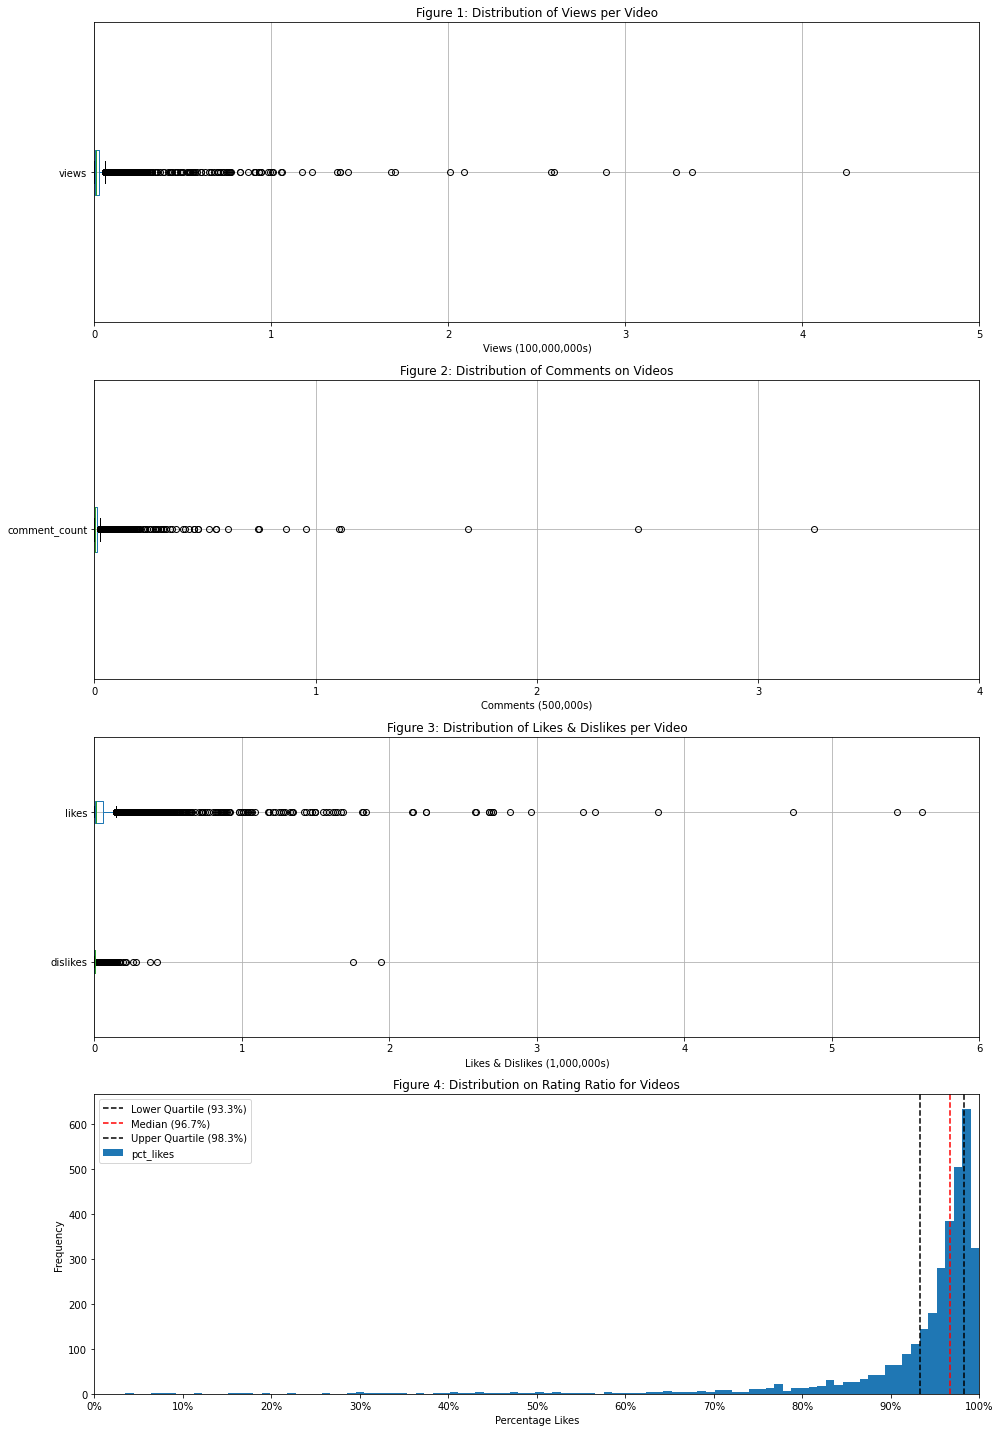

In [12]:
fig,axes=plt.subplots(figsize=(14,20),nrows=4,ncols=1,tight_layout=True)

# Views
x_step=int(pow(10,8))
x_lim_max=int(x_step*np.ceil(unique_df["views"].max()/x_step))
unique_df.boxplot(column=["views"],ax=axes[0],vert=False)
axes[0].set_title("Figure 1: Distribution of Views per Video")
axes[0].set_xlabel("Views ({:,}s)".format(x_step))
axes[0].set_xlim((0,x_lim_max))
axes[0].set_xticks([i for i in range(0,x_lim_max+1,x_step)])
axes[0].set_xticklabels([str(i) for i in range(0,1+int(x_lim_max/x_step))])

# comments
x_step=int(5*pow(10,5))
x_lim_max=int(x_step*np.ceil(unique_df["comment_count"].max()/x_step))
unique_df.boxplot(column=["comment_count"],ax=axes[1],vert=False)
axes[1].set_title("Figure 2: Distribution of Comments on Videos")
axes[1].set_xlabel("Comments ({:,}s)".format(x_step))
axes[1].set_xlim((0,x_lim_max))
axes[1].set_xticks([i for i in range(0,x_lim_max+1,x_step)])
axes[1].set_xticklabels([str(i) for i in range(0,1+int(x_lim_max/x_step))])

# Ratings
x_step=int(pow(10,6))
x_lim_max=int(x_step*np.ceil(unique_df["likes"].max()/x_step))
unique_df.boxplot(column=["dislikes","likes"],ax=axes[2],vert=False)
axes[2].set_title("Figure 3: Distribution of Likes & Dislikes per Video")
axes[2].set_xlabel("Likes & Dislikes ({:,}s)".format(x_step))
axes[2].set_xlim((0,x_lim_max))
axes[2].set_xticks([i for i in range(0,x_lim_max+1,x_step)])
axes[2].set_xticklabels([str(i) for i in range(0,1+int(x_lim_max/x_step))])

unique_df["pct_likes"].plot.hist(ax=axes[3],bins=100)
axes[3].set_title("Figure 4: Distribution on Rating Ratio for Videos")
axes[3].set_xlabel("Percentage Likes")
axes[3].set_ylabel("Frequency")
axes[3].set_xlim((0,1))
axes[3].set_xticks([i/10 for i in range(11)])
axes[3].set_xticklabels(["{}%".format(int(100*(i/10))) for i in range(11)])
quartiles=unique_df["pct_likes"].quantile([.25,.5,.75])
axes[3].axvline(x=quartiles[.25],c="black",ls="--",label="Lower Quartile ({:.1f}%)".format(100*quartiles[.25]))
axes[3].axvline(x=quartiles[.5],c="red",ls="--",label="Median ({:.1f}%)".format(100*quartiles[.5]))
axes[3].axvline(x=quartiles[.75],c="blacK",ls="--",label="Upper Quartile ({:.1f}%)".format(100*quartiles[.75]))
axes[3].legend()

plt.show()

The boxplots *Figures 1,2 & 3* show that the majority of videos have views, ratings and comment counts which fall into a very small part of the overall range of values. This suggests that using a log value may be useful, at least when assessing the fit of my prediction.

*Figure 4* shows that most trending videos have an overwhelmingly favourable like to dislike ratio, with the median video having 96.7% of it's ratings being likes. Although there are still some videos which have a negative like to dislike ratio.

## Tags

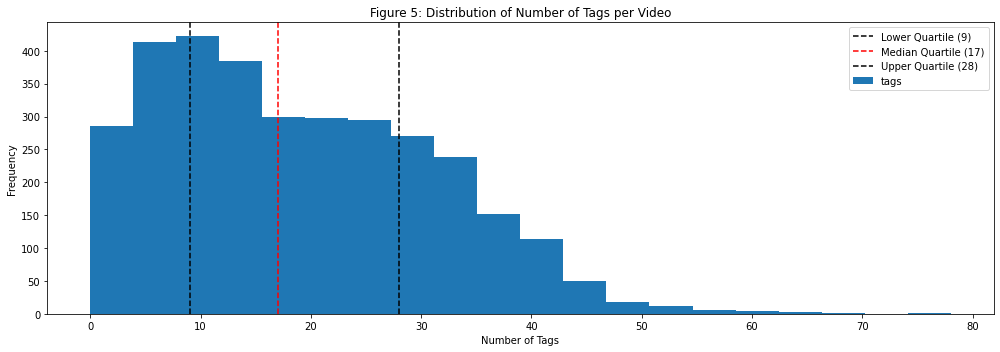

In [13]:
fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=1,tight_layout=True)

# Number of tags
num_tags=unique_df["tags"].str.len()
num_tags.plot.hist(bins=20,ax=axes)
quartiles=num_tags.quantile([.25,.5,.75]).astype(int)

# add labels
axes.set_xlabel("Number of Tags")
axes.set_title("Figure 5: Distribution of Number of Tags per Video")

# add quartile line markers
axes.axvline(quartiles[.25],c="black",ls="--",label="Lower Quartile ({})".format(quartiles[.25]))
axes.axvline(quartiles[.5],c="red",ls="--",label="Median Quartile ({})".format(quartiles[.5]))
axes.axvline(quartiles[.75],c="black",ls="--",label="Upper Quartile ({})".format(quartiles[.75]))

axes.legend()

In [14]:
tag_counts={}
for tag_set in unique_df["tags"]:
    for tag in tag_set:
        if tag in tag_counts: tag_counts[tag]+=1
        else: tag_counts[tag]=1
            
tag_counts=pd.Series(tag_counts)
tag_counts=tag_counts.sort_values(ascending=False) # sort from most to least popular
tag_counts[:10] # ten most popular

funny          319
comedy         263
music          206
humor          161
interview      152
comedian       138
video          138
late night     131
celebrities    128
funny video    126
dtype: int64

The majority of the most popular tags refer to humour. It is worth remembering that there are 3,272 videos in the data set so no tags appear in more than 10% of videos.

In [15]:
print("Mean: {:.1f}".format(tag_counts.mean()))
tag_counts.value_counts(normalize=True).sort_index()

Mean: 1.9


1      0.770320
2      0.112297
3      0.043575
4      0.020657
5      0.012809
         ...   
152    0.000031
161    0.000031
206    0.000031
263    0.000031
319    0.000031
Length: 91, dtype: float64

The majority of tags are only used by a single video and so will be ignored in my model.

In [16]:
# How many videos have purely unique tags
def tags_are_unique(tags):
    tag_value=0
    for tag in tags: tag_value+=tag_counts[tag]
    return (tag_value==len(tags))

def num_unique_tags(tags):
    unique_tags=0
    for tag in tags:
        if (tag_counts[tag]==1): unique_tags+=1
    return unique_tags

print("{}/{} videos have all unique tags".format(unique_df["tags"].apply(tags_are_unique).sum(),unique_df.shape[0]))

328/3266 videos have all unique tags


## Categories

In [20]:
unique_df["category_name"].value_counts(normalize=True)

Music                   0.268218
Entertainment           0.262707
People & Blogs          0.086957
Sports                  0.064911
Comedy                  0.062768
Film & Animation        0.060625
Howto & Style           0.057563
Gaming                  0.052970
News & Politics         0.038885
Science & Technology    0.012860
Pets & Animals          0.012554
Education               0.011329
Autos & Vehicles        0.004287
Travel & Events         0.003062
Shows                   0.000306
Name: category_name, dtype: float64

Music & Entertainment are by far the most popular categories for videos, and combined account for more than half the trending videos. Ofcourse these categories are not well defined and so may not provide much information about a video compared to other features.

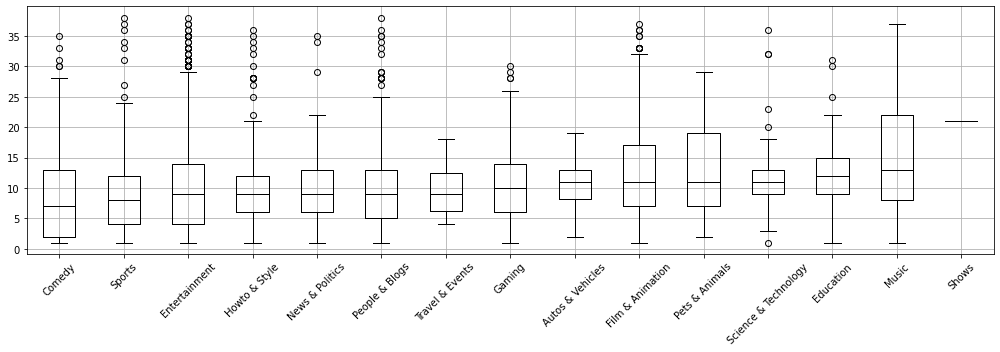

In [38]:
def boxplot_sorted(df,by,column,ax,colour):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    bp=df2[meds.index].boxplot(ax=ax,color=dict(boxes=colour, whiskers=colour, medians=colour, caps=colour))
    return enumerate(meds.index) # sorted order

fig,axes=plt.subplots(figsize=(14,5),nrows=1,ncols=1,tight_layout=True)
boxplot_sorted(unique_df,"category_name","total_days_trending",axes,"black")
axes.xaxis.set_tick_params(rotation=45)